In [1]:
!pip install changeforest

In [13]:
import numpy as np
from changeforest import changeforest
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score as sklearn_adjusted_rand_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_generator = np.random.default_rng(12)

# Rand Index and Adjusted Rand index

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

let $tp,fp,tn$ and $fn$ be true positive pairs,false positive pairs,true negative pairs and false negative pairs.Then,

$$ RI = \frac{tp+tn}{tp+tn+fp+fn}$$

The adjusted rand index is rand index adjusted for chance 

$$ ARI = 2 \times \frac{tp \times tn - fn \times fp}{(tp + fn) \times (fn + tn) + (tp + fp) \times (fp + tn)}$$

Function to caculate the same

```
def calculate_rand_index_and_adjusted_rand_index(y_true,y_pred):
  pairs = []
  for i in range(len(y_true)):
    for j in range(i+1,len(y_true)):
      pairs.append((i,j))
  tp,tn,fp,fn =0,0,0,0
  for i,j in pairs:
    if y_true[i] == y_true[j] and y[j]==y[i]:
      tp+=1
    elif y_true[i] != y_true[j] and y[j]!=y[i]:
      tn+=1
    elif y_true[i]==y_true[j] and  y[j]!=y[i]:
      fn+=1
    elif y_true[i]!=y_true[j] and y[j]==y[i]:
      fp+=1
  rand_index = (tp+tn)/ (tp+tn+fp+fn)
  adjusted_rand_index = 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
  return rand_index,adjusted_rand_index

```

or you can use 
```
sklearn.metrics.adjusted_rand_score
```



In [4]:
def adjusted_rand_score(true_changepoints, estimated_changepoints):
    """Compute the adjusted rand index between two sets of changepoints.

    Args:
      true_changepoints (List) : list of true change points.
      estimated_changepoints (List) : list of estimated change points.
    """
    true_changepoints = np.array(true_changepoints, dtype=np.int_)
    estimated_changepoints = np.array(estimated_changepoints, dtype=np.int_)

    y_true = np.zeros(true_changepoints[-1])
    for i, (start, stop) in enumerate(zip(true_changepoints[:-1], true_changepoints[1:])):
        y_true[start:stop] = i

    y_estimated = np.zeros(estimated_changepoints[-1])
    for i, (start, stop) in enumerate(zip(estimated_changepoints[:-1], estimated_changepoints[1:])):
        y_estimated[start:stop] = i

    return sklearn_adjusted_rand_score(y_true, y_estimated)

# Change in Mean

In this experiment, I will perform change point detection on a generated dataset drawn from a set of normal distribution with different means. The number of observations  (n)  is 600, and the number of features is 5.

### Dataset
The dataset consisted of segments 1, 2 and 3 concatenated in that order.

* Segment 1 and segment 3 are both drwan from a normal distribution with $n=200$ mean $=0$ and std $=1$.
* segment 2 is drawn from normal distribution with $n=200$, mean $=2$ and std $=1$.
* Changes in mean occur at $t=200$ and $t=400$.

### Mean Calculation

Mean is the measure of central tendency of data.

$$ Mean(x) = E(x) \\ \\ \text{where} \ x \ \text{is a random variable.}$$

For descrite random varaiables the equation can be rewritten as

$$ Mean(x) = \frac{\Sigma_{i=1}^{n} x_{i}}{n} \\ \\ \text{where} \ x \ \text{is a random variable.} $$

In [5]:
def generate_change_in_mean_data(dataset_generator,n=600,d=5,mu=2):
  X = dataset_generator.normal(0, 1, (n, d))
  X[int(n / 3) : int(2 * n / 3), :] += mu
  orginal_change_points = [0, n / 3, 2 * n / 3, n]
  return X,orginal_change_points

In [6]:
X,orginal_change_points = generate_change_in_mean_data(dataset_generator)

In [7]:
result = changeforest(X, "random_forest", "bs")

In [8]:
result

                    best_split max_gain p_value
(0, 600]                   200   77.798   0.005
 ¦--(0, 200]                 6    -1.95    0.67
 °--(200, 600]             400  242.923   0.005
     ¦--(200, 400]         224   -6.764    0.82
     °--(400, 600]         412   -9.047    0.66

In [9]:
result.split_points()

[200, 400]

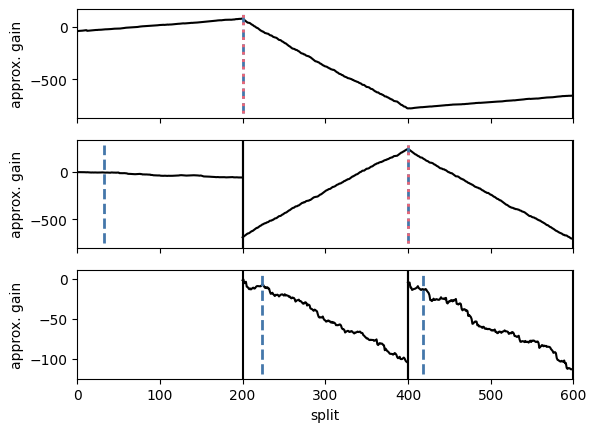

In [12]:
result.plot().show()

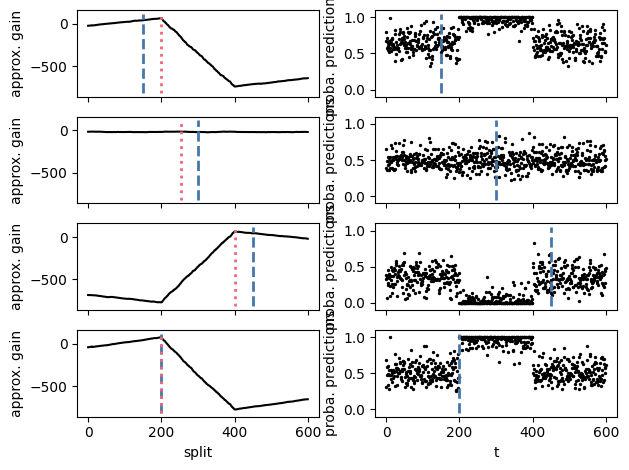

In [14]:
result.optimizer_result.plot().show()

In [13]:
pbar = tqdm(total=500)
pbar.set_description("Simulating Change in Mean: ")
ari_change_in_mean = []

for i in range(500):
  X,orginal_change_points = generate_change_in_mean_data(dataset_generator)
  result = changeforest(X, "random_forest", "bs")
  estimated_changepoints =[0] + result.split_points()+[600]
  score = adjusted_rand_score(orginal_change_points,estimated_changepoints)
  ari_change_in_mean.append(score)
  pbar.update(1)
pbar.close()

Simulating Change in Mean: : 100%|██████████| 500/500 [01:26<00:00,  5.77it/s]


In [14]:
np.mean(ari_change_in_mean),np.var(ari_change_in_mean)

(0.9855944462905414, 0.0012398515820303015)

In [17]:
import plotly.graph_objects as go
fig = go.Figure()
steps =  list(range(1,501))
fig.add_trace(go.Scatter(x=steps, y=ari_change_in_mean,
                    mode='lines',
                    name='ARI Score'))
fig.add_trace(go.Scatter(x=steps, y=[np.mean(ari_change_in_mean)]*500,
                    mode='lines',
                    name='Mean ARI Score'))

fig.update_layout(
    title="Change in Mean",
    xaxis_title="Experiment Number",
    yaxis_title="ARI Score"
    )

fig.write_html("fig1.html", include_plotlyjs='cdn') 

Click [here](https://wajidmanzoor.github.io/Change-Point-detection-using-Random-Forest/notebooks/fig1.html) to check the above graph for change in mean simmulations